In [2]:
import sys
sys.path.append("..")
import importlib
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt

import system.from_higher_basis_truncation_tunable_full_cosine as system
importlib.reload(system)
import utils.solver as solver
importlib.reload(solver)
import pulse.tukey as tukey
importlib.reload(tukey)
import pulse.tukey_derivative as tukey_derivative
importlib.reload(tukey_derivative)
import utils.expectation_values as expect
importlib.reload(expect)
import optimization.grape as grape
importlib.reload(grape)
import utils.graph as graph
importlib.reload(graph)

pass

# known
1. Drive system with tukey pulse
2. Look at floquet basis during flat top driving period
3. Plot population of floquet states as a function of time over the existing plot

# exploratory
1. Figure out how floquet state relates to our original basis
    1. specifically could we stop driving sooner to achieve the same resolution


8.067223706634019


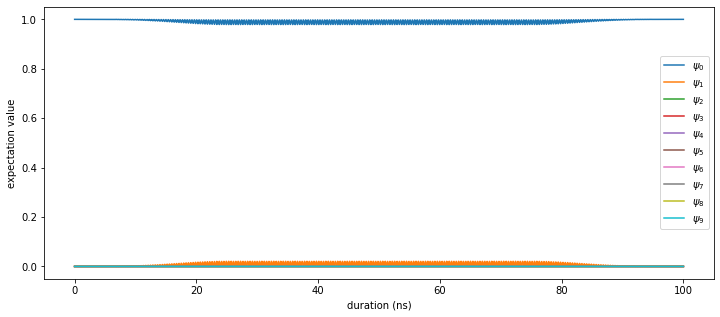

In [3]:
amp = 0.5 * 2 * np.pi
offset = 0.25
freq = system.first_energy_spacing/3 - offset # angular GHz
print(freq)
rc = 0.5
dur = 100
tlist = np.linspace(0, dur, dur*20)
tukey.setup(amp, freq, rc, tlist)

solution = solver.time_evolve(system.H0, system.H1, tukey.pulse_func, tlist, system.basis_states[0], pbar=True)

graph.graph_solution(solution, system)

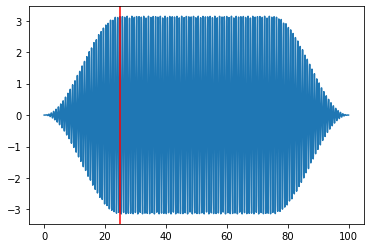

In [4]:
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx

percent_starting_ramp = rc /2
time_end_starting_ramp = dur * percent_starting_ramp
time_start_ending_ramp = dur - time_end_starting_ramp # symmetric
index_at_starting_ramp = find_nearest(tlist, time_end_starting_ramp)

plt.plot(tlist, tukey.get_pulse(tlist))
plt.axvline(time_end_starting_ramp, c='red')
plt.show()

state_at_start_of_steady_state = solution.states[index_at_starting_ramp+10]

# First try at Floquet

In [65]:
import qutip.floquet as floquet
import qutip.qobj
amp = 0
test_freq = 5
def test(t, args):
    return amp * np.cos(t * test_freq)

# find the floquet modes for the time-dependent hamiltonian
H = [system.H0, [system.H1, test]]
period = 2*np.pi / (freq) # perhaps freq/(2*np.pi)
f_modes_0, f_energies = floquet.floquet_modes(H, period)

# decompose the inital state in the floquet modes
f_coeff = floquet.floquet_state_decomposition(f_modes_0, f_energies, state_at_start_of_steady_state)

In [97]:
import qutip.propagator as p
import qutip

H_diag_test = np.diag(system.energies)
H_test = [qutip.Qobj(H_diag_test), [system.H1, test]]
prop = p(qutip.Qobj(system.H0), period, c_op_list=[], options=qutip.Options(nsteps=10000))

In [71]:
2*np.pi / ((1/3) - offset / 24.95167112)

19.43369603612247

In [72]:
6*np.pi

18.84955592153876

In [73]:

period*24.95167112 - (2*np.pi)*3

0.5841401146623575

In [68]:
system.energies

array([  0.        ,  24.95167112,  48.59909786,  70.81008699,
        91.54465215, 110.66598226, 131.40691739, 150.17156406,
       181.48219641, 203.44257216])

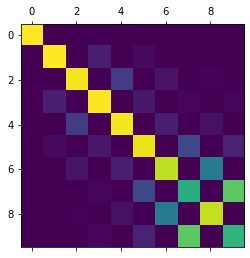

In [98]:
plt.matshow(np.abs(prop.full().data))

In [99]:
np.angle(prop.diag())

array([-2.67685351,  3.02467916, -2.8395241 , -1.26841543,  1.45887977,
       -0.82484659,  1.61549195, -0.1959149 ,  0.63567253,  2.0750431 ])

In [103]:
prop.eigenenergies()

array([-0.99288674+0.11906269j, -0.9516204 -0.30727615j,
       -0.89391386-0.44823879j, -0.6157426 +0.7879071j ,
       -0.21805637+0.97594611j,  0.14868915+0.98888483j,
        0.28785157-0.95767518j,  0.6178539 -0.78629958j,
        0.88306417+0.46922979j,  0.9669476 -0.25507848j])

In [117]:
e, v = qutip.Qobj(-1j*sp.linalg.logm(prop.full())).eigenstates()

In [118]:
np.real(e)

array([-2.82926328, -2.67679852, -1.27881367, -0.90479006, -0.25792192,
        0.48842398,  1.4215539 ,  1.79061663,  2.23414919,  3.02224685])

In [130]:
v[0]

Quantum object: dims = [[10], [1]], shape = (10, 1), type = ket
Qobj data =
[[-0.01693784-2.31618656e-08j]
 [ 0.        +0.00000000e+00j]
 [ 0.99418016+0.00000000e+00j]
 [ 0.        +0.00000000e+00j]
 [ 0.10151425+9.66354598e-09j]
 [ 0.        +0.00000000e+00j]
 [ 0.03116343-1.16125415e-07j]
 [ 0.        +0.00000000e+00j]
 [ 0.00652868-5.42229985e-08j]
 [ 0.        +0.00000000e+00j]]

In [134]:
system.basis_states[2]

Quantum object: dims = [[10], [1]], shape = (10, 1), type = ket
Qobj data =
[[-0.01693784]
 [ 0.        ]
 [ 0.99418015]
 [ 0.        ]
 [ 0.10151425]
 [ 0.        ]
 [ 0.03116354]
 [ 0.        ]
 [ 0.0065288 ]
 [ 0.        ]]

In [33]:
# n = 9
system.energies % freq

array([0.        , 0.75      , 0.19575562, 6.27229733, 2.80519137,
       5.79207407, 2.33133808, 4.96153735, 4.00327487, 1.7619795 ])

In [34]:
freq/2

4.0336118533170096

In [291]:
# test zero
amp = 0
f_modes_0, f_energies = floquet.floquet_modes(qutip.Qobj(system.H0), period)
f_energies

array([ 3.43684475,  3.63260013, -1.82518782, -2.29904168, -0.62710637,
       -3.88037918,  1.64191814,  1.16169482,  0.33115589, -2.86851023])

In [148]:
# test non-zero
amp = 0
f_modes_0, f_energies = floquet.floquet_modes(H, period)
f_energies

array([ 3.43684475,  3.63260013, -1.82518782, -2.29904168, -0.62710637,
       -3.88037918,  1.64191814,  1.16169482,  0.33115589, -2.86851023])

In [147]:
# numpy v
w,v = np.linalg.eig(prop.full())
np.angle(w) / period


array([-3.43684475, -3.63260013,  1.82518782,  2.29904168,  0.62710637,
        3.88037918, -1.64191814, -1.16169482, -0.33115589,  2.86851023])

In [152]:
# qutip v
e, v = qutip.Qobj(-1j*sp.linalg.logm(prop.full())).eigenstates()
quasi_e = np.real(e) / period

In [294]:
quasi_e

array([-3.63260013, -3.43684475, -1.64191814, -1.16169482, -0.33115589,
        0.62710637,  1.82518782,  2.29904168,  2.86851023,  3.88037918])

In [154]:
system.energies

array([  0.        ,  24.95167112,  48.59909786,  70.81008699,
        91.54465215, 110.66598226, 131.40691739, 150.17156406,
       181.48219641, 203.44257216])

In [155]:
quasi_e

array([-3.63260013, -3.43684475, -1.64191814, -1.16169482, -0.33115589,
        0.62710637,  1.82518782,  2.29904168,  2.86851023,  3.88037918])

In [212]:
v

array([Quantum object: dims = [[10], [1]], shape = (10, 1), type = ket
       Qobj data =
       [[-0.01693784-2.31618656e-08j]
        [ 0.        +0.00000000e+00j]
        [ 0.99418016+0.00000000e+00j]
        [ 0.        +0.00000000e+00j]
        [ 0.10151425+9.66354598e-09j]
        [ 0.        +0.00000000e+00j]
        [ 0.03116343-1.16125415e-07j]
        [ 0.        +0.00000000e+00j]
        [ 0.00652868-5.42229985e-08j]
        [ 0.        +0.00000000e+00j]]                                ,
       Quantum object: dims = [[10], [1]], shape = (10, 1), type = ket
       Qobj data =
       [[9.99849652e-01+0.00000000e+00j]
        [0.00000000e+00+0.00000000e+00j]
        [1.64645391e-02+2.30754057e-08j]
        [0.00000000e+00+0.00000000e+00j]
        [5.41336554e-03+2.69198454e-09j]
        [0.00000000e+00+0.00000000e+00j]
        [5.16033142e-04-1.16328379e-09j]
        [0.00000000e+00+0.00000000e+00j]
        [1.46948149e-04-6.37750089e-10j]
        [0.00000000e+00+0.00000000e+0

In [249]:
S = np.zeros((10,10), dtype=np.complex128)
for i in range(0,len(v)):
    vec = np.reshape(v[i].full(), (10))
    for j in range(0, len(vec)):
        S[i][j] = vec[j]
# print(D[0])
# print(v[0])
# D = np.swapaxes(D, 0, 1)
S

array([[-1.69378356e-02-2.31618656e-08j,  0.00000000e+00+0.00000000e+00j,
         9.94180157e-01+0.00000000e+00j,  0.00000000e+00+0.00000000e+00j,
         1.01514249e-01+9.66354598e-09j,  0.00000000e+00+0.00000000e+00j,
         3.11634307e-02-1.16125415e-07j,  0.00000000e+00+0.00000000e+00j,
         6.52867580e-03-5.42229985e-08j,  0.00000000e+00+0.00000000e+00j],
       [ 9.99849652e-01+0.00000000e+00j,  0.00000000e+00+0.00000000e+00j,
         1.64645391e-02+2.30754057e-08j,  0.00000000e+00+0.00000000e+00j,
         5.41336554e-03+2.69198454e-09j,  0.00000000e+00+0.00000000e+00j,
         5.16033142e-04-1.16328379e-09j,  0.00000000e+00+0.00000000e+00j,
         1.46948149e-04-6.37750089e-10j,  0.00000000e+00+0.00000000e+00j],
       [ 0.00000000e+00+0.00000000e+00j, -5.12225507e-02-2.80773344e-08j,
         0.00000000e+00+0.00000000e+00j,  9.81429188e-01+0.00000000e+00j,
         0.00000000e+00+0.00000000e+00j,  1.74044518e-01+1.43211409e-06j,
         0.00000000e+00+0.00000000e+

In [256]:
D = np.reshape(np.array([vec.full() for vec in v]), (10,10))

In [257]:
qutip.Qobj(np.einsum('ji,jk,lk->il',D,prop.full(),D))

Quantum object: dims = [[10], [10]], shape = (10, 10), type = oper, isherm = False
Qobj data =
[[-1.67130027e-04-5.39671751e-05j  1.51403261e-02+7.59189994e-03j
  -1.47285000e-02+4.90012748e-02j -2.87212835e-03+3.65538215e-03j
   3.64758014e-03-9.62004503e-04j  1.18005212e-03+6.27006720e-04j
  -1.27781115e-04-8.50031285e-04j  6.96950049e-04-3.11930828e-03j
   4.77605217e-04-6.11146043e-04j -9.91419096e-01+1.18886692e-01j]
 [ 4.81820189e-02+1.55578781e-02j  7.39866355e-04+3.70994829e-04j
   3.27992335e-03-1.09087665e-02j  8.96845661e-02-1.14121929e-01j
   4.00568071e-01-1.05663740e-01j -4.47881192e-04-2.37949991e-04j
   1.21822443e-03+8.10334023e-03j  1.77174463e-04-7.92468479e-04j
  -5.52297231e-01+7.06722103e-01j -3.88439290e-04+4.66006149e-05j]
 [ 1.91783587e-02+6.19266924e-03j -8.88528749e-01-4.45538509e-01j
  -5.12048307e-05+1.70363735e-04j  2.04169803e-03-2.59831538e-03j
  -3.32911463e-03+8.79012584e-04j  3.50496608e-02+1.86233137e-02j
  -4.60167217e-03-3.06106306e-02j  2.04280129

In [227]:
qutip.Qobj(np.matmul(np.matrix(D), np.matmul(np.matrix(prop.full()), np.matrix(D).getH())))

Quantum object: dims = [[10], [10]], shape = (10, 10), type = oper, isherm = False
Qobj data =
[[-9.89430275e-01+1.16066511e-01j  9.60559485e-04+1.80336375e-04j
  -1.34335164e-03+9.85882987e-03j  1.17602023e-02-9.66427258e-03j
  -3.52438481e-03-2.63583625e-03j -5.68173050e-02+4.82738148e-02j
   6.63526302e-03-2.20121762e-03j -2.28402716e-02+1.90655626e-02j
  -1.99607543e-02+1.41146069e-02j -7.97327040e-03+7.17167830e-03j]
 [ 9.60481984e-04+1.80240080e-04j -3.18818990e-01+5.72725981e-01j
  -1.97810365e-03+6.00398746e-04j  3.37009891e-02+4.01864983e-02j
  -1.65549618e-01+1.22163733e-01j -1.03238453e-02+2.01117186e-02j
   5.71380534e-01-3.72601339e-01j  2.52950479e-03+1.48896193e-02j
   1.38104387e-01-2.00028301e-01j  1.26727784e-03+6.92873296e-03j]
 [-1.34333661e-03+9.85875352e-03j -1.97745681e-03+6.01586638e-04j
  -8.84195666e-01-4.32705894e-01j  5.24427366e-03+2.01553214e-03j
  -8.59216573e-02-1.37137351e-01j  5.61223135e-03+2.74074713e-03j
  -2.93242897e-02-3.81998601e-02j -2.77952229

In [263]:
D = np.reshape(np.array([vec.full() for vec in v]), (10,10))
diagonalized_propagator = qutip.Qobj( np.matrix(D) * np.matrix(prop.full()) * np.matrix(D).getH() )

In [266]:
diagonalized_propagator

Quantum object: dims = [[10], [10]], shape = (10, 10), type = oper, isherm = False
Qobj data =
[[-9.51620400e-01-3.07276154e-01j -1.74061347e-08+4.25188393e-08j
   0.00000000e+00+0.00000000e+00j  0.00000000e+00+0.00000000e+00j
   0.00000000e+00+0.00000000e+00j -1.39437784e-07-5.90149423e-08j
  -2.81102512e-08-3.31136471e-08j -1.71136608e-08-2.99377261e-08j
   0.00000000e+00+0.00000000e+00j  0.00000000e+00+0.00000000e+00j]
 [ 1.74061345e-08-4.25188418e-08j -8.93913860e-01-4.48238787e-01j
   0.00000000e+00+0.00000000e+00j  0.00000000e+00+0.00000000e+00j
   0.00000000e+00+0.00000000e+00j -3.46510041e-09-1.78906980e-09j
  -3.53527229e-10-4.87292990e-10j -6.95420152e-10-1.46542598e-09j
   0.00000000e+00+0.00000000e+00j  0.00000000e+00+0.00000000e+00j]
 [ 0.00000000e+00+0.00000000e+00j  0.00000000e+00+0.00000000e+00j
   2.87851571e-01-9.57675178e-01j  3.60306975e-06+1.87112878e-06j
   1.25029416e-06+1.29366564e-06j  0.00000000e+00+0.00000000e+00j
   0.00000000e+00+0.00000000e+00j  0.00000000

In [296]:
np.linalg.eigvals(prop.full())

array([-0.89391386-0.44823879j, -0.9516204 -0.30727615j,
        0.14868915+0.98888483j, -0.21805637+0.97594611j,
        0.88306417+0.46922979j, -0.99288674+0.11906269j,
        0.28785157-0.95767518j,  0.6178539 -0.78629958j,
        0.9669476 -0.25507848j, -0.6157426 +0.7879071j ])

In [301]:
diagonalized_propagator[0][0][0] - np.linalg.eigvals(prop.full())[1]

(9.636735853746359e-14-5.873079800267078e-14j)

In [302]:
prop.full()

array([[-8.93916419e-01-4.48178555e-01j,  0.00000000e+00+0.00000000e+00j,
         1.36554346e-03-1.83141657e-03j,  0.00000000e+00+0.00000000e+00j,
        -3.64916544e-03-5.54580507e-03j,  0.00000000e+00+0.00000000e+00j,
        -2.67921092e-04-8.36641392e-05j,  0.00000000e+00+0.00000000e+00j,
        -2.17627904e-04-3.62800348e-05j,  0.00000000e+00+0.00000000e+00j],
       [ 0.00000000e+00+0.00000000e+00j, -9.89470540e-01+1.16212435e-01j,
         0.00000000e+00+0.00000000e+00j, -6.28535304e-02+5.32892001e-02j,
         0.00000000e+00+0.00000000e+00j, -2.08145249e-02+1.40619647e-02j,
         0.00000000e+00+0.00000000e+00j, -1.98439232e-03+4.08592290e-03j,
         0.00000000e+00+0.00000000e+00j,  3.64516356e-05+8.94136973e-04j],
       [ 1.36554375e-03-1.83141698e-03j,  0.00000000e+00+0.00000000e+00j,
        -9.39119432e-01-2.92633556e-01j,  0.00000000e+00+0.00000000e+00j,
        -1.11318578e-01-1.30973527e-01j,  0.00000000e+00+0.00000000e+00j,
        -3.46590916e-02-3.92610185e-

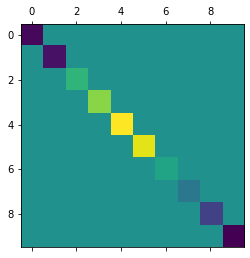

In [287]:
plt.matshow(np.real((diagonalized_propagator)))

In [289]:
evals, evecs = np.linalg.eig(diagonalized_propagator.full())

In [293]:
np.angle(evals) % f_energies

array([ 0.60758148,  0.95580162, -1.33676384, -0.50842505, -0.45976521,
       -1.27881367,  0.73712808,  0.9037729 ,  0.24721384, -2.71477361])

In [292]:
f_energies

array([ 3.43684475,  3.63260013, -1.82518782, -2.29904168, -0.62710637,
       -3.88037918,  1.64191814,  1.16169482,  0.33115589, -2.86851023])

In [19]:
system.basis_states[4]

Quantum object: dims = [[10], [1]], shape = (10, 1), type = ket
Qobj data =
[[-0.00357031]
 [ 0.        ]
 [-0.10634629]
 [ 0.        ]
 [ 0.95577956]
 [ 0.        ]
 [ 0.25769676]
 [ 0.        ]
 [ 0.09357105]
 [ 0.        ]]

In [93]:
# calculate the wavefunctions using the from the floquet modes
fstates = []
tlist = np.linspace(time_end_starting_ramp, time_start_ending_ramp, int(time_start_ending_ramp*10))
for t in tlist:
    fstates.append(floquet.floquet_wavefunction_t(f_modes_0, f_energies, f_coeff, t, H, period))

expect_values = expect.get_all_expectation_values(fstates, system.basis_states)


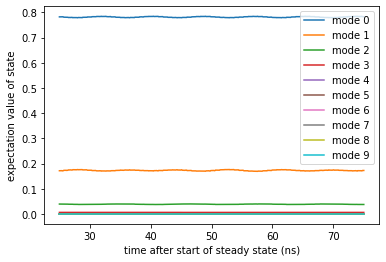

In [94]:
for i in range(0, len(expect_values)):
    plt.plot(tlist, expect_values[i], label=r'mode %i' % i)
plt.xlabel("time after start of steady state (ns)")
plt.ylabel("expectation value of state")
plt.legend()
plt.show()

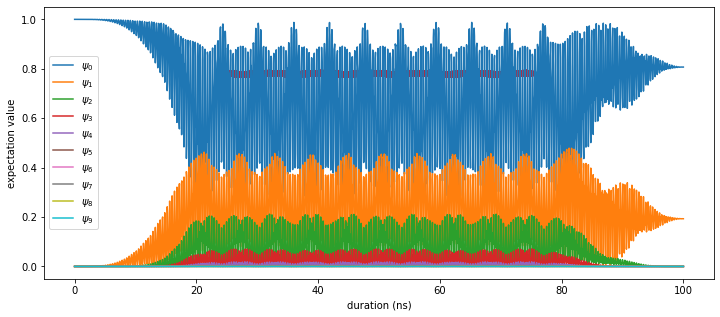

In [95]:
graph.graph_solution(solution, system)

for i in range(0, len(expect_values)-7):
    plt.scatter(tlist, expect_values[i], label=r'mode %i' % i, c="red")

# I think the problem is I need to be more clever with how I setup my hamiltonian for this part, I don't think I could use the pulse

# Second try at Floquet

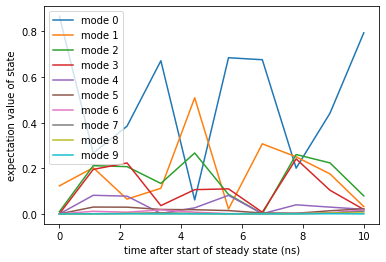

In [71]:
# find the floquet modes for the time-dependent hamiltonian
steady_state_perturbation = [system.H1 * amp, 'cos(wd * (t-%f))' % time_start_ending_ramp]
H = [system.H0, steady_state_perturbation]
period = 2*np.pi / (freq)
f_modes_0, f_energies = floquet.floquet_modes(H, period, args={"wd": freq})

# decompose the inital state in the floquet modes
f_coeff = floquet.floquet_state_decomposition(f_modes_0, f_energies, state_at_start_of_steady_state)

# calculate the wavefunctions using the from the floquet modes
fstates = []
# tlist = np.linspace(time_end_starting_ramp, time_start_ending_ramp, int(time_start_ending_ramp/3))
tlist = np.linspace(0, 10, 10)
for t in tlist:
    fstates.append(floquet.floquet_wavefunction_t(f_modes_0, f_energies, f_coeff, t, H, period, args={"wd": freq}))

expect_values = expect.get_all_expectation_values(fstates, system.basis_states)

for i in range(0, len(expect_values)):
    plt.plot(tlist, expect_values[i], label=r'mode %i' % i)
plt.xlabel("time after start of steady state (ns)")
plt.ylabel("expectation value of state")
plt.legend()
plt.show()

# lets try the whole damn thing in floquet space

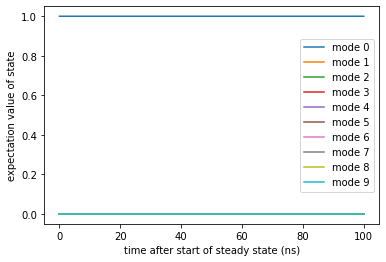

In [57]:
# lets try the whole damn thing in floquet space
# clearly is not supposed to work, and it doesnt

H = [system.H0, [system.H1, tukey.pulse_func]]
period = 2*np.pi / (freq/2*np.pi)
f_modes_0, f_energies = floquet.floquet_modes(H, period)
f_coeff = floquet.floquet_state_decomposition(f_modes_0, f_energies, system.basis_states[0])

# calculate the wavefunctions using the from the floquet modes
fstates = []
tlist = np.linspace(0, 100, 100*10)
for t in tlist:
    fstates.append(floquet.floquet_wavefunction_t(f_modes_0, f_energies, f_coeff, t, H, period))

expect_values = expect.get_all_expectation_values(fstates, system.basis_states)

for i in range(0, len(expect_values)):
    plt.plot(tlist, expect_values[i], label=r'mode %i' % i)
plt.xlabel("time after start of steady state (ns)")
plt.ylabel("expectation value of state")
plt.legend()
plt.show()